In [244]:
!pip install colorama

In [245]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import time 
from IPython.display import clear_output
import io
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

# Build the enviroment

## Define actions

In [246]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [382]:
class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]


      #Rewards of each state
      reward = 1.0 if is_done(s) else 0.0
      reward = -103.0 if pit(s) else reward
      #Generating rewards
      pre_help1=lambda s :s in [40,41,42,28,48]
      pre_help2=lambda s :s in [10]
      reward = -1 if pre_help1(s) else reward
      reward = 0.01 if pre_help2(s) else reward


      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -10.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -10.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -10.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -10.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

In [383]:
env =  GridworldEnv()
# action_space_size = env.action_space.n
# state_space_size = env.observation_space.n

In [384]:
Q_table = np.ones((state_space_size, action_space_size))

print(Q_table.shape)

(100, 4)


# Hyper parameters

In [385]:
num_of_episodes = 20000
max_steps_per_episode = 200

learning_rate = 0.7
discount_rate = 0.99

exploration_rate = 1

#The training process


In [386]:
rewards_of_all_episodes = []

for episode in range(num_of_episodes):
    state = env.reset()
        
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        
        random_number = random.uniform(0,1)
        
        if random_number > exploration_rate:
            action = np.argmax(Q_table[state,:]) 
            
        else:
            action = env.action_space.sample() 
        
        new_state, reward, done, info = env.step(action)

        Q_table[state, action] = Q_table[state, action] * (1 - learning_rate) \
        + learning_rate * (reward + discount_rate * np.max(Q_table[new_state,:]))

        state = new_state
        rewards_current_episode = rewards_current_episode + reward
        
        if done == True:
            break
                
    exploration_rate = 1 - np.log(episode + 1) / np.log(num_of_episodes + 1)
        
    rewards_of_all_episodes.append(rewards_current_episode)   

# Visualize the training process

Average reward per thousand episodes 

1000 : -45.78322999999996
2000 : -22.518170000000158
3000 : -15.668859999999835
4000 : -12.336969999999846
5000 : -11.812969999999849
6000 : -9.282909999999857
7000 : -8.505349999999867
8000 : -7.541459999999864
9000 : -7.172329999999838
10000 : -6.407509999999862
11000 : -4.374479999999859
12000 : -4.17724999999991
13000 : -3.157179999999947
14000 : -2.9071199999999098
15000 : -2.700269999999927
16000 : -2.387129999999951
17000 : -1.3801800000000075
18000 : -0.921050000000008
19000 : -0.163030000000002
20000 : -0.13302000000000683


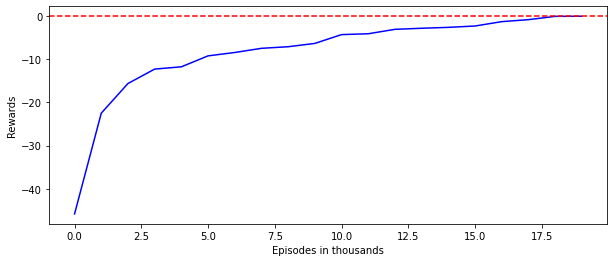



Q Table:
[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 9.80100000e-01  9.70299000e-01  9.80100000e-01  9.90000000e-01]
 [ 9.70299000e-01  9.60596010e-01  9.70299000e-01  9.80100000e-01]
 [ 9.60596010e-01  9.50990050e-01 -1.01009404e+02  9.70299000e-01]
 [ 9.50990050e-01  9.41480149e-01  9.41480149e-01  9.60596010e-01]
 [ 9.41480149e-01  9.32065348e-01  9.32065348e-01  9.50990050e-01]
 [ 9.32065348e-01  9.22744694e-01  9.22744694e-01  9.41480149e-01]
 [ 9.22744694e-01  9.13517247e-01  9.13517248e-01  9.32065348e-01]
 [ 9.13533977e-01  9.04396662e-01  9.04416745e-01  9.22744694e-01]
 [ 9.06217017e-01  9.07125060e-01  9.07711229e-01  9.13517249e-01]
 [ 1.00000000e+00  9.90100000e-01  9.90100000e-01  1.00000000e+00]
 [ 9.80100000e-01  9.70299000e-01  9.70299000e-01  9.90000000e-01]
 [ 9.70299000e-01 -1.01009404e+02  9.60596010e-01  9.80100000e-01]
 [-1.02039404e+02 -1.02058520e+02 -1.02049010e+02 -1.02029701e+02]
 [ 9.50990050e-01  9.32065348e-01  9.41480149e-01 -

In [387]:
rewards_per_thousand_episodes = np.split(np.array(rewards_of_all_episodes),
                               num_of_episodes/1000)

reward_value_list = []

count = 1000
print("Average reward per thousand episodes \n")
for i in rewards_per_thousand_episodes:
    print(count, ":", str(sum(i) / 1000))
    
    current_reward_value = sum(i) / 1000
    reward_value_list.append(current_reward_value)
    count = count + 1000
    
    
plt.figure(figsize=(10,4))
#plt.ylim(0,1)

plt.plot(reward_value_list, 'b', label='Training loss')
plt.axhline(y=0,ls='--',color='red')
plt.xlabel('Episodes in thousands')
plt.ylabel('Rewards')
#plt.legend()
plt.show()

    

print("\n")
print("Q Table:")
print(Q_table)
    

In [389]:
# Watch our agent play Frozen Lake by playing the best action 
# from each state according to the Q-table

for episode in range(3):
    state = env.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)

    for step in range(30):        
        clear_output(wait=True)
        env._render()
        time.sleep(0.3)

        action = np.argmax(Q_table[state,:])        
        new_state, reward, done, info = env.step(action)
        
        if done:
            clear_output(wait=True)
            env._render()
            print('finished')
            print("****You reached the goal!****")
            time.sleep(3)
            clear_output(wait=True)
         
    
        state = new_state
        
env.close()

  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
finished
****You reached the goal!****
